# Customer segmentation - Dimensional Reduction and Clustering

# Introduction
The problem statement for customer segmentation involves identifying distinct customer segments based on their demographic, behavioural, and psychographic characteristics, and developing targeted marketing strategies that resonate with each segment. The goal is to better understand the needs and preferences of different customer groups, and to develop marketing strategies that increase customer engagement and loyalty.

Content : 
1. Importing Libraries
2. Data Loading
3. Data Cleaning
4. Data Preprocessing 
5. Dimensionality reduction by PCA and T-SNE
6. Clustering
7. Evaluating 
8. Profiling
9. Conclusion

# 1.Importing Libraries

In [1]:
# Importing Common Libraries
import pandas as pd
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Importing colour palet
import matplotlib.colors
pal = ['#009473', '#00537c', '#b4b4b4', '#da3e21']
cmap = matplotlib.colors.ListedColormap(pal)

# Import libraries for pre-processing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Import libraries for clustering
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
import sklearn.cluster as cluster
import time
import plotly.graph_objects as go

#Remove warnings
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

np.random.seed(42)

# 2.Data Loading

In [2]:
path = "/kaggle/input/customer-personality-analysis/marketing_campaign.csv"
df = pd.read_csv(path, sep = '\t')

# 3. Data Cleaning
#### 3.1 Understanding data

In [3]:
#Check the dataset
df.head()

ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  
0              3         11         1  
1              3         11         0  
2              3         11         0  
3              3         11         0  
4              3         11         0  

[5 rows x 29 columns]

In [4]:
#Check the shape of the dataset
df.shape

(2240, 29)

In [5]:
# Rename columns for clarity and ease of use
df = df.rename(columns = {
    'MntWines' : 'Wines',
    'MntFruits' : 'Fruits',
    'MntMeatProducts' : 'Meat',
    'MntFishProducts' : 'Fish',
    'MntSweetProducts' : 'Sweets',
    'MntGoldProds' : 'Gold'
})

In [6]:
print(df.columns)

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'Wines', 'Fruits', 'Meat', 'Fish',
       'Sweets', 'Gold', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')


In [7]:
# List of column names based on data type
numeric_columns = ['Income', 'Kidhome',
       'Teenhome', 'Recency', 'Wines', 'Fruits', 'Meat', 'Fish',
       'Sweets', 'Gold', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']

bool_columns = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response']

category_columns = ['Education', 'Marital_Status']

date_columns = ['Year_Birth', 'Dt_Customer']

In [8]:
# Check the basic information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   Wines                2240 non-null   int64  
 10  Fruits               2240 non-null   int64  
 11  Meat                 2240 non-null   int64  
 12  Fish                 2240 non-null   int64  
 13  Sweets               2240 non-null   int64  
 14  Gold                 2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

As you can see : \
1. There are missing values in Income \
2. Dt_Customer indicates the date a customer joined the supermarket is not parsed as Date Time \
3. There are some categorical features in our data frame (as there are some features are object data types). Thus we will need to encode them into numeric forms.

#### 3.2 Check and Handle missing values


In [9]:
df.isna().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
Wines                   0
Fruits                  0
Meat                    0
Fish                    0
Sweets                  0
Gold                    0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

As you can see, there are 24 missing values in the Income column. \
These missing values need to be filled in order to procede.

In [10]:
income_missing = df[df['Income'].isna()]

In [11]:
income_missing.shape

(24, 29)

In [12]:
#Calculate the mean values of income grouped by education level
group_means = df.groupby('Education')['Income'].mean()

#Impute missing values in the "Income" column
df['Income'] = df['Income'].fillna(df['Education'].map(group_means))

In [13]:
#Re-check the missing values of the dataset
print('Missing data: ', df.isna().sum().sum())

Missing data:  0


#### 3.3 Cleaning Data

Our next steps involve feature engineering, which includes creating new attributes and modifying existing ones. The following are the specific steps we plan to take:

1. We will create a new attribute called "Days_since_enrolment" to indicate the number of days since a customer started shopping at the supermarket.
2. We will extract the "Age" of a customer by using their "Year_Birth" attribute.
3. We will create a new attribute called "Spent" to indicate the total amount of money a customer spent in various categories over a period of 2 years.
4. We will group the "Marital Status" attribute into two categories: "Alone" and "Partner".
5. We will create a new attribute called "Children" to indicate the total number of children in a household, combining both kids and teenagers.
6. We will create a new attribute called "Family_Size" to further clarify the size of a household.
7. We will create a new attribute called "Is_Parent" to indicate whether a customer is a parent or not.
8. We will simplify the "Education" attribute by grouping its values into three categories.
9. We will drop some of the redundant features that are not necessary for our analysis.

In [14]:
# Convert 'Dt_Customer' to a date time format
df['Dt_customer'] = pd.to_datetime(df['Dt_Customer'], format = '%d-%m-%Y')

#Find the max and min dates in the Dt_customer column
max_date = df['Dt_customer'].max()
min_date = df['Dt_customer'].min()
print("The newest customer's enrolment date in the records:", max_date)
print("The oldest customer's enrolment date in the records:", min_date)

#Calculate the number of days between the enrolment date and the maximum date
df['Days_since_enrolment'] = df['Dt_customer'].apply(lambda x: (max_date - x).days)

#Calculate the age of customers
df['Age'] = 2023 - df['Year_Birth']

The newest customer's enrolment date in the records: 2014-06-29 00:00:00
The oldest customer's enrolment date in the records: 2012-07-30 00:00:00


In [15]:
# Count of column values
print('Values of Education levels : ', df['Education'].value_counts())
print('Values of Marital Status : ', df['Marital_Status'].value_counts())

Values of Education levels :  Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: Education, dtype: int64
Values of Marital Status :  Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64


In [16]:
#Group marital status into only two status 
df['Marital_Status'] = df['Marital_Status'].apply(lambda x: "Partner" if x in {"Married", "Together"} else "Alone")


#Segment education levels in three groups
df['Education'] = df['Education'].replace({'Basic' : 'Undergrade', 
                                           '2n Cycle' : 'Undergrade', 
                                           'Graduation' : 'Graduate', 
                                           'Master' : 'Postgraduate',
                                           'PhD' : 'Postgraduate'})

                                           
print('Values of Education levels: ', df['Education'].value_counts())
print('Values of Marital Status: ', df['Marital_Status'].value_counts())

Values of Education levels:  Graduate        1127
Postgraduate     856
Undergrade       257
Name: Education, dtype: int64
Values of Marital Status:  Partner    1444
Alone       796
Name: Marital_Status, dtype: int64


In [17]:
#Calculate the total children living the household
df['Children'] = df['Kidhome'] + df['Teenhome']

#Calculate the total members in the household
df['Family_Size'] = df['Marital_Status'].replace({"Alone" : 1, "Partner" : 2}) + df['Children']

#Check pertain parenthood
df['Is_Parent'] = np.where(df.Children > 0, 1, 0)

In [18]:
#Total spendings on various categories
df['Spent'] = df['Wines'] + df['Fruits'] + df['Meat'] + df['Fish'] + df['Sweets'] + df['Gold']

In [19]:
#Drop some of redundant attributes
to_drop = ['Dt_customer', 'Z_CostContact', 'Z_Revenue', 'Year_Birth', 'ID']
df = df.drop(to_drop, axis = 1)

display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Education             2240 non-null   object 
 1   Marital_Status        2240 non-null   object 
 2   Income                2240 non-null   float64
 3   Kidhome               2240 non-null   int64  
 4   Teenhome              2240 non-null   int64  
 5   Dt_Customer           2240 non-null   object 
 6   Recency               2240 non-null   int64  
 7   Wines                 2240 non-null   int64  
 8   Fruits                2240 non-null   int64  
 9   Meat                  2240 non-null   int64  
 10  Fish                  2240 non-null   int64  
 11  Sweets                2240 non-null   int64  
 12  Gold                  2240 non-null   int64  
 13  NumDealsPurchases     2240 non-null   int64  
 14  NumWebPurchases       2240 non-null   int64  
 15  NumCatalogPurchases  

None

#### 3.4 Feature EDA


In [20]:
df.describe().T.style.bar(subset=['mean','min','50%'],
                          color=pal[0]).highlight_max(subset=['max'],color=pal[3]).set_caption('Basic Stats of The Data')

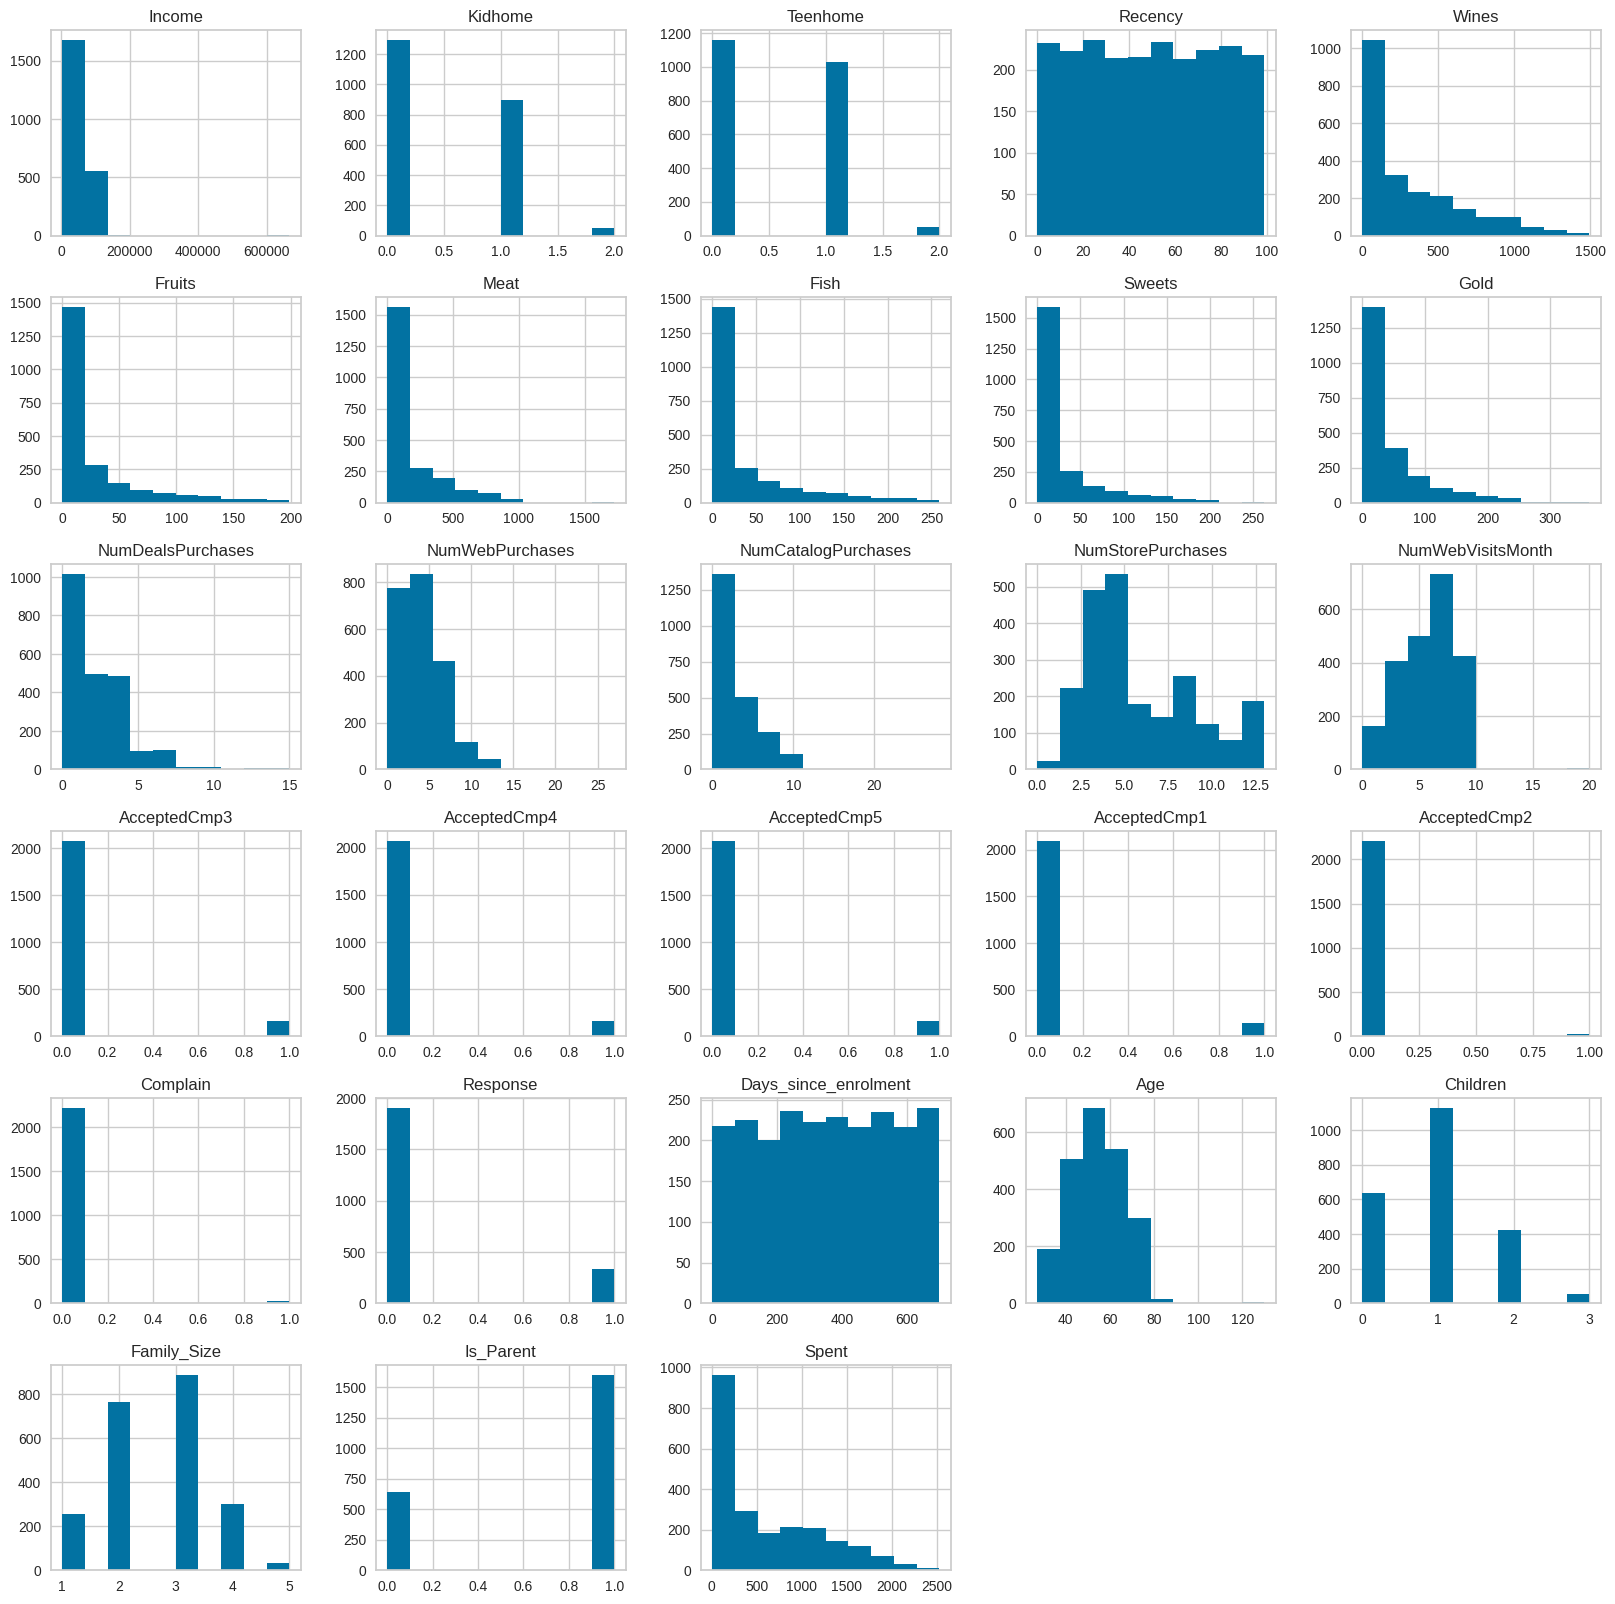

In [21]:
#Plot histograms of columns
df.hist(figsize=(20,20))
plt.show()

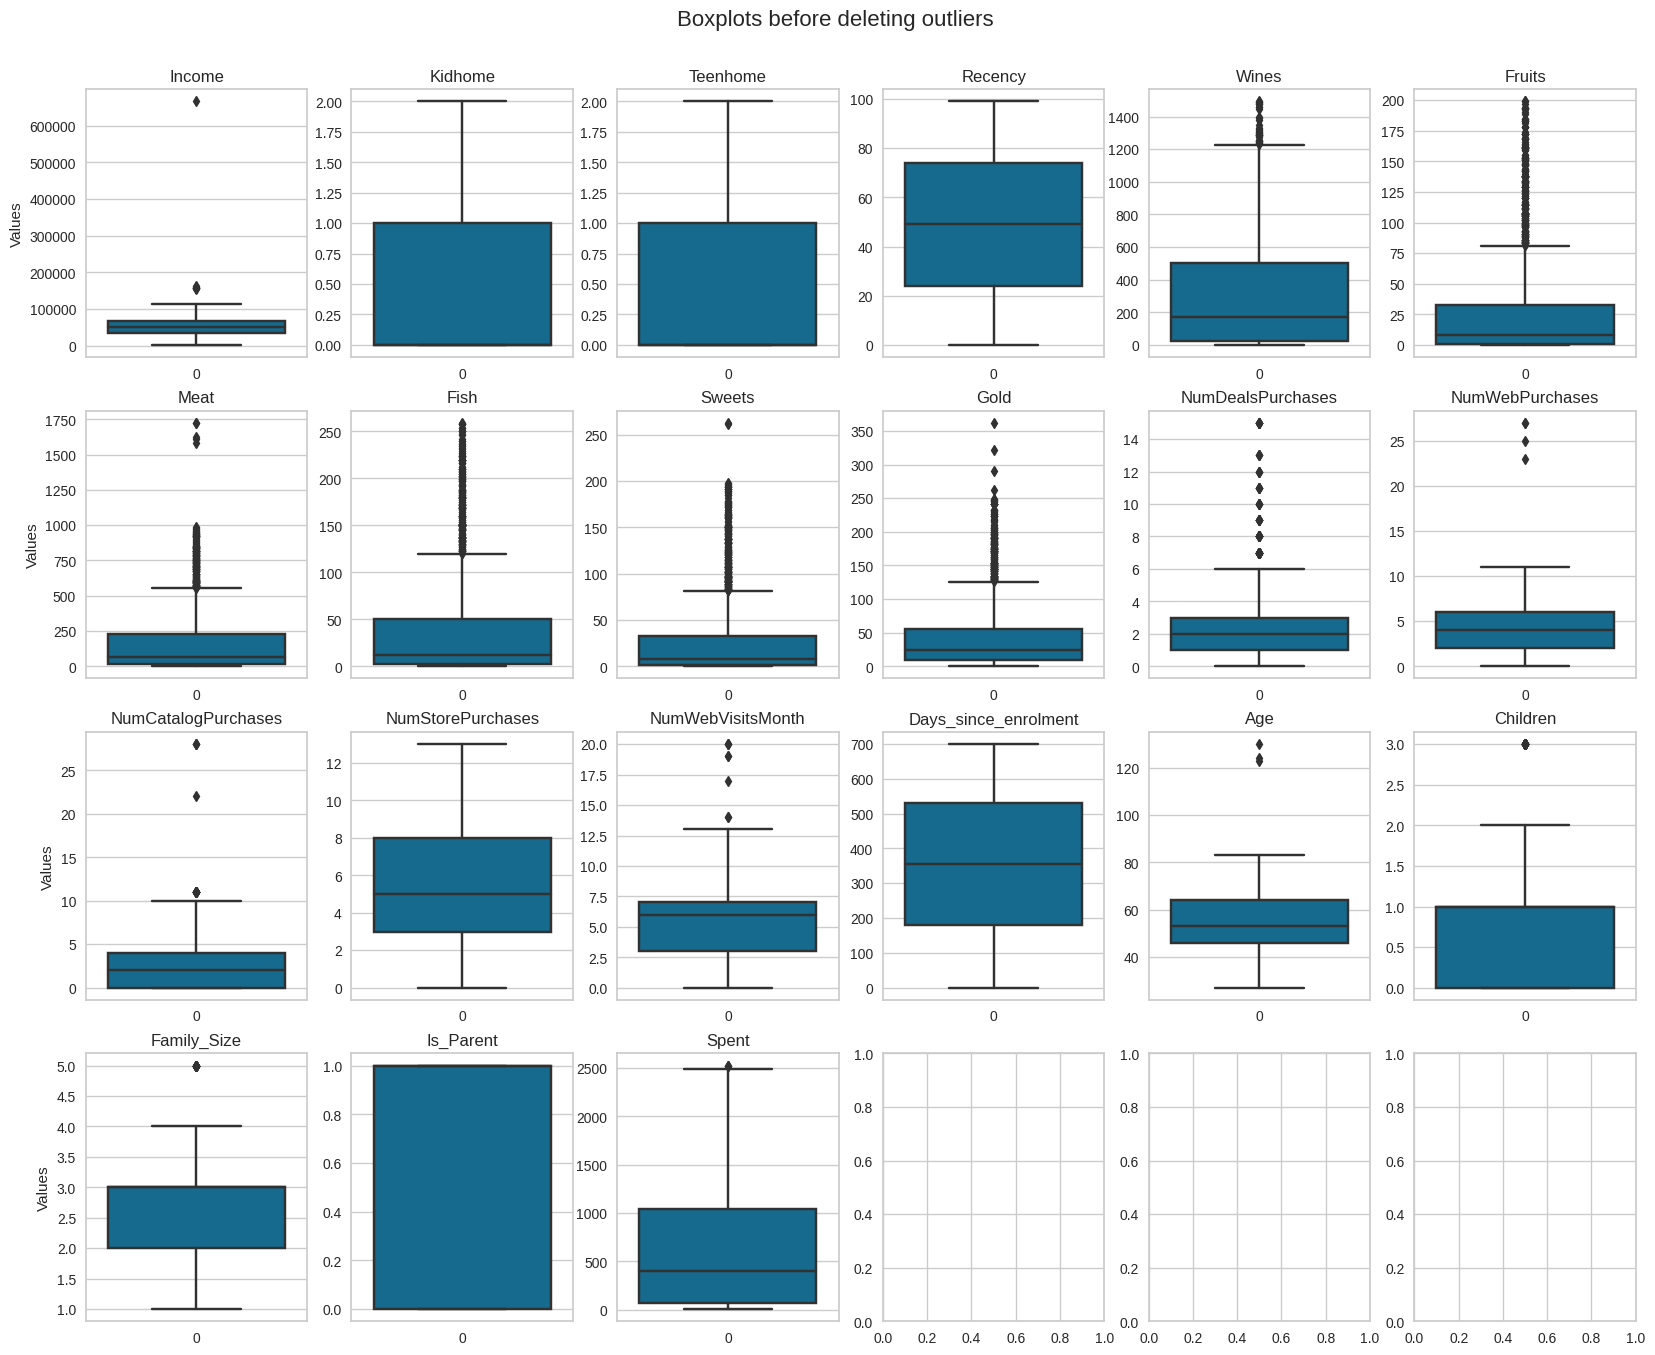

In [22]:
#list numeric columns of the data set
numeric_columns = ['Income', 'Kidhome',
       'Teenhome', 'Recency', 'Wines', 'Fruits', 'Meat', 'Fish',
       'Sweets', 'Gold', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 
       'Days_since_enrolment', 'Age', 'Children',
       'Family_Size', 'Is_Parent', 'Spent']

def boxplots_custom(dataset, columns_list, rows, cols, suptitle,size=(20,16)):
    fig, axs = plt.subplots(rows, cols,  figsize=size)
    fig.suptitle(suptitle,y=0.93, size=16)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        if i % cols == 0:
            axs[i].set_ylabel('Values')
        sns.boxplot( data=dataset[data], orient='v', ax=axs[i])
        axs[i].set_title(data)
        
boxplots_custom(dataset=df, columns_list=numeric_columns, rows=4, cols=6, suptitle='Boxplots before deleting outliers')

From the box plots, we can see the age which is more than 90 and the income which is more than 600000 are unusual, thus we need to drop them.

In [23]:
#Drop outliers by setting a cap in the 'Income' and 'Age' columns
df= df[(df['Age'] < 90)]
df = df[(df['Income'] < 600000)]
print('The total number of data points after removing outliers:', len(df))

The total number of data points after removing outliers: 2236


#### 3.5 Correlation


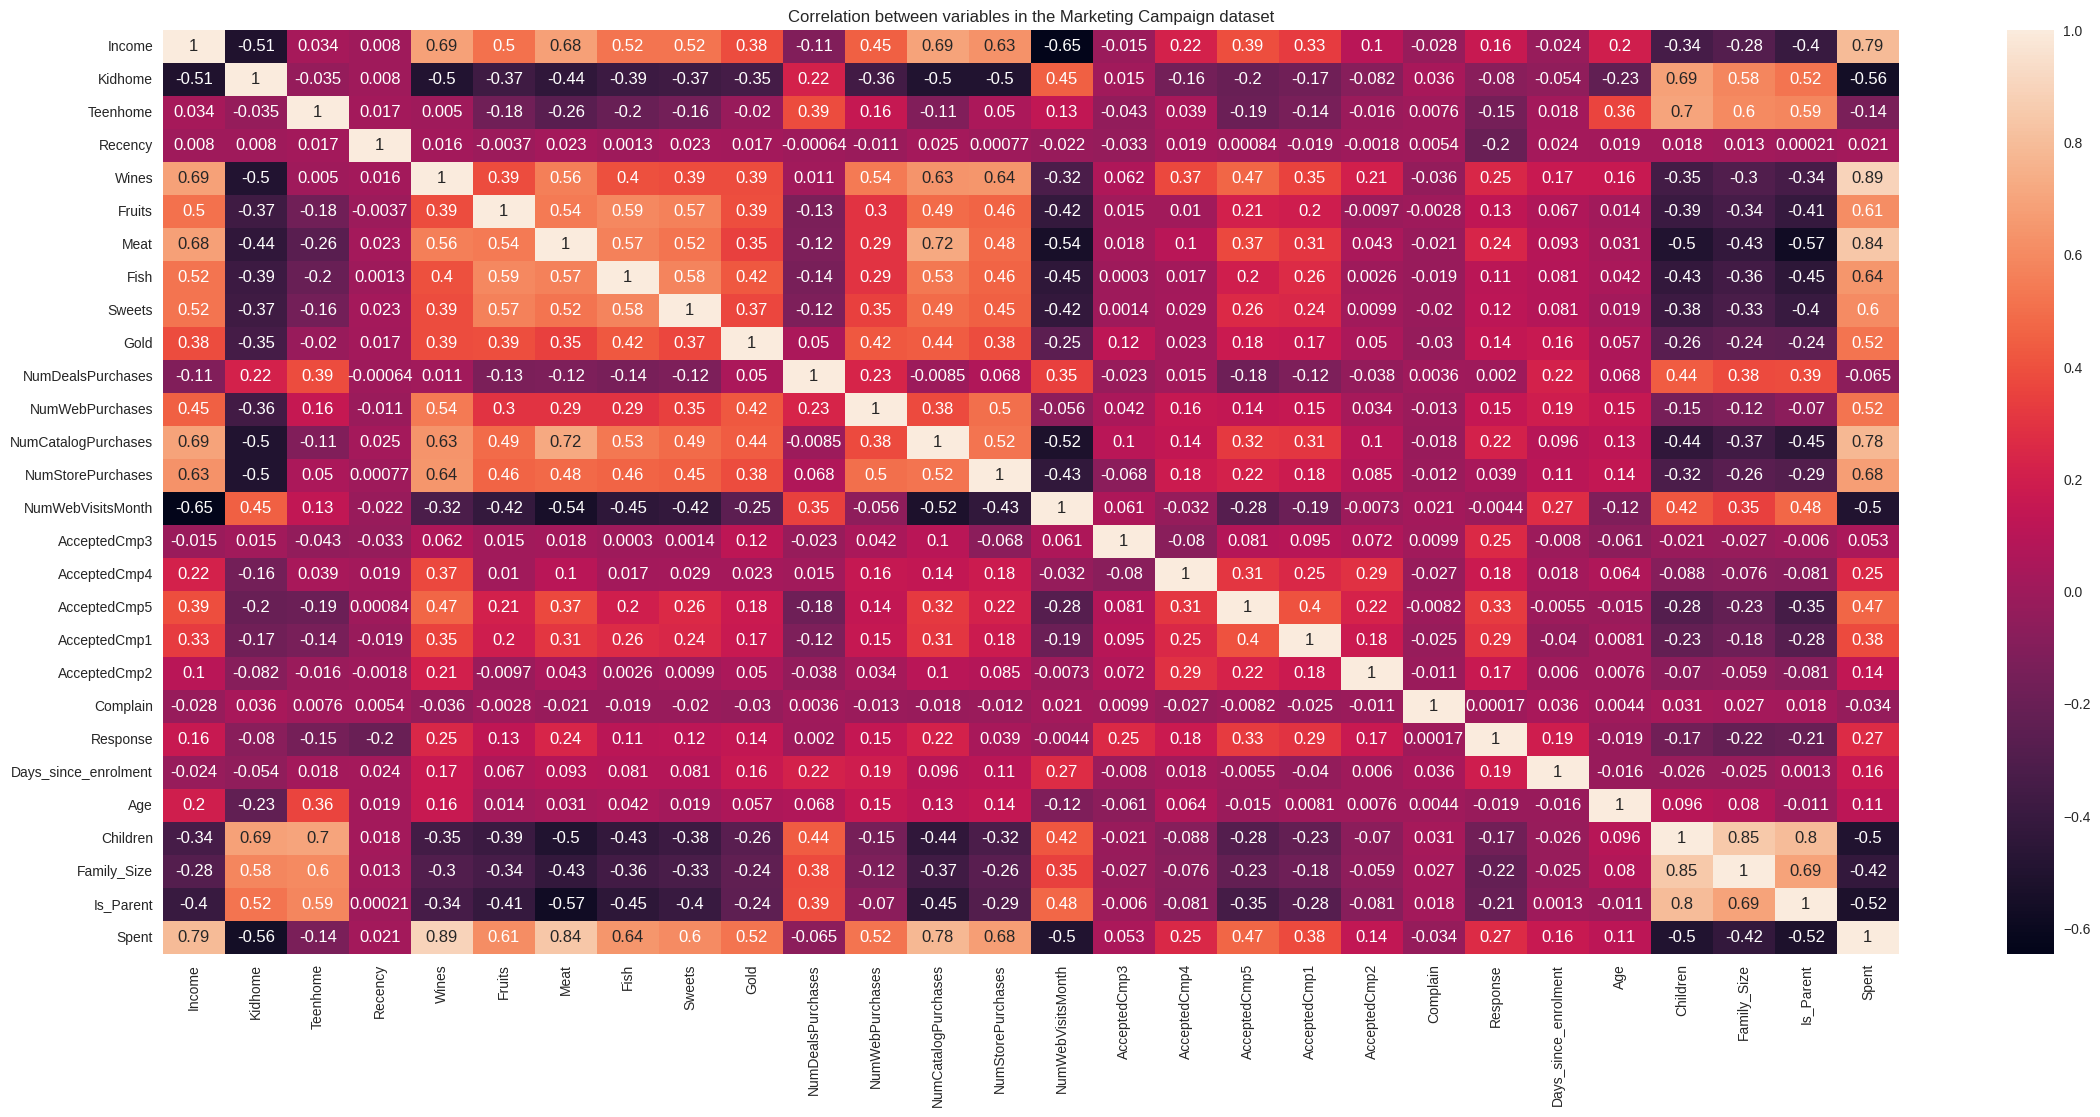

In [24]:
#Find the correlation between the variables
plt.figure(figsize=(28, 12))
sns.heatmap(df.corr(),
            annot = True)
plt.title('Correlation between variables in the Marketing Campaign dataset')
plt.show()

#### Note: 
The is a strong relationship between Income and Spent with 0.79

<a id="sec-4"></a>
# 4. DATA PRE-PROCESSING
Prior to conducting clustering operations, we will be carrying out data preprocessing which comprises of two stages:
* Encoding the categorical columns using label encoding technique.
* Scaling the data utilizing the standard scaler approach.
<a id="sub-4-1"></a>

#### 4.1. Label enconding the categorical columns

In [25]:
# create an instance of LabelEncoder
le = LabelEncoder()

#copy original dataset
ds = df.copy()
# select categorical columns
categorical_cols = ds.select_dtypes(include=['object']).columns.tolist()

# label encode each column in the list
for col in categorical_cols:
    ds[col] = le.fit_transform(ds[col])
    
print(ds.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2236 entries, 0 to 2239
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Education             2236 non-null   int64  
 1   Marital_Status        2236 non-null   int64  
 2   Income                2236 non-null   float64
 3   Kidhome               2236 non-null   int64  
 4   Teenhome              2236 non-null   int64  
 5   Dt_Customer           2236 non-null   int64  
 6   Recency               2236 non-null   int64  
 7   Wines                 2236 non-null   int64  
 8   Fruits                2236 non-null   int64  
 9   Meat                  2236 non-null   int64  
 10  Fish                  2236 non-null   int64  
 11  Sweets                2236 non-null   int64  
 12  Gold                  2236 non-null   int64  
 13  NumDealsPurchases     2236 non-null   int64  
 14  NumWebPurchases       2236 non-null   int64  
 15  NumCatalogPurchases  

In [26]:
ds.head()

Education  Marital_Status   Income  Kidhome  Teenhome  Dt_Customer  \
0          0               0  58138.0        0         0           80   
1          0               0  46344.0        1         1          157   
2          0               1  71613.0        0         0          444   
3          0               1  26646.0        1         0          199   
4          1               1  58293.0        1         0          390   

   Recency  Wines  Fruits  Meat  ...  AcceptedCmp1  AcceptedCmp2  Complain  \
0       58    635      88   546  ...             0             0         0   
1       38     11       1     6  ...             0             0         0   
2       26    426      49   127  ...             0             0         0   
3       26     11       4    20  ...             0             0         0   
4       94    173      43   118  ...             0             0         0   

   Response  Days_since_enrolment  Age  Children  Family_Size  Is_Parent  \
0         1                   663   66         0            1          0   
1         0                   113   69         2            3          1   
2         0                   312   58         0            2          0   
3         0                   139   39         1            3          1   
4         0                   161   42         1            3          1   

   Spent  
0   1617  
1     27  
2    776  
3     53  
4    422  

[5 rows x 31 columns]

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2236 entries, 0 to 2239
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Education             2236 non-null   object 
 1   Marital_Status        2236 non-null   object 
 2   Income                2236 non-null   float64
 3   Kidhome               2236 non-null   int64  
 4   Teenhome              2236 non-null   int64  
 5   Dt_Customer           2236 non-null   object 
 6   Recency               2236 non-null   int64  
 7   Wines                 2236 non-null   int64  
 8   Fruits                2236 non-null   int64  
 9   Meat                  2236 non-null   int64  
 10  Fish                  2236 non-null   int64  
 11  Sweets                2236 non-null   int64  
 12  Gold                  2236 non-null   int64  
 13  NumDealsPurchases     2236 non-null   int64  
 14  NumWebPurchases       2236 non-null   int64  
 15  NumCatalogPurchases  

<a id="sub-4-2"></a>
#### 4.2. Scale data using Standard Scaler

In [28]:
df_before_scale = ds.drop(bool_columns, axis = 1)

In [29]:
#Get data for scaling by removing boolean columns
df_before_scale = ds.drop(bool_columns, axis = 1) #new data frame with numeric

# create an instance of the StandardScaler class
scaler = StandardScaler()

# fit the scaler to the data and transform it
scaled_data = scaler.fit_transform(df_before_scale)


# create a new dataframe with the scaled data
df_scaled = pd.DataFrame(scaled_data, columns=df_before_scale.columns)

df_scaled.head()

Education  Marital_Status    Income   Kidhome  Teenhome  Dt_Customer  \
0   -0.89438       -1.347635  0.288195 -0.824939 -0.930615    -1.303716   
1   -0.89438       -1.347635 -0.262715  1.032627  0.905974    -0.898592   
2   -0.89438        0.742041  0.917627 -0.824939 -0.930615     0.611419   
3   -0.89438        0.742041 -1.182829  1.032627 -0.930615    -0.677614   
4    0.57070        0.742041  0.295435  1.032627 -0.930615     0.327306   

    Recency     Wines    Fruits      Meat  ...  NumWebPurchases  \
0  0.306856  0.983228  1.554170  1.679746  ...         1.407639   
1 -0.383971 -0.871064 -0.636431 -0.713455  ...        -1.110921   
2 -0.798467  0.362159  0.572177 -0.177201  ...         1.407639   
3 -0.798467 -0.871064 -0.560893 -0.651409  ...        -0.751127   
4  1.550344 -0.389661  0.421101 -0.217088  ...         0.328256   

   NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  \
0             2.509801          -0.552429           0.692865   
1            -0.568970          -1.167738          -0.131421   
2            -0.226884           1.293496          -0.543564   
3            -0.911056          -0.552429           0.280722   
4             0.115201           0.062879          -0.131421   

   Days_since_enrolment       Age  Children  Family_Size  Is_Parent     Spent  
0              1.529793  1.016868 -1.264308    -1.758810  -1.584362  1.680176  
1             -1.191143  1.273264  1.395139     0.445618   0.631169 -0.962202  
2             -0.206659  0.333146 -1.264308    -0.656596  -1.584362  0.282541  
3             -1.062517 -1.290693  0.065416     0.445618   0.631169 -0.918994  
4             -0.953679 -1.034298  0.065416     0.445618   0.631169 -0.305762  

[5 rows x 24 columns]

# 5. DIMENSIONALITY REDUCTION BY PCA and T-SNE
Dimensionality reduction refers to the technique of decreasing the number of random variables that are being analyzed by obtaining a group of primary variables. PCA and T-SNE are methods used for reducing the dimensionality of these datasets, which enhances interpretability while minimizing any loss of information.

#### 5.1 Fit our standardized data using PCA

In [30]:
# Fit our standardized data using PCA
pca = PCA()

# Fit PCA on scaled data
pca.fit(df_scaled)

PCA()

#### 5.2. Plot cumulative variance ratio and find a suitable number of PCs

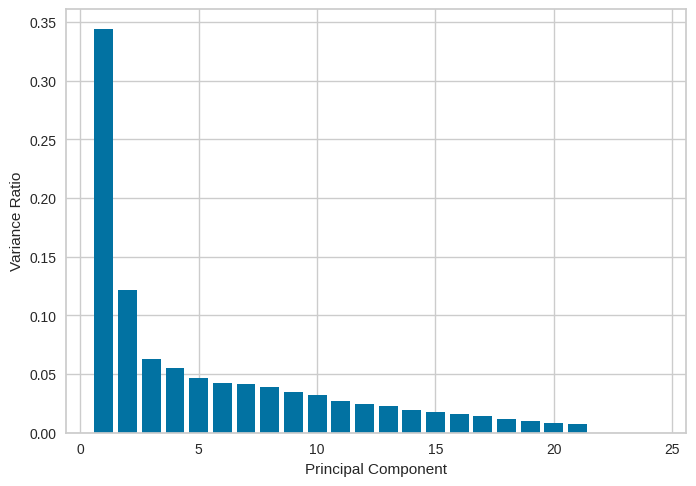

Percentage of cumulative variance of PCs:  [ 34.3800087   46.54600053  52.84266421  58.32044418  62.95866467
  67.2216796   71.40777344  75.29832462  78.78590971  81.98947836
  84.6536075   87.1425948   89.45138685  91.3581562   93.14338038
  94.78031735  96.23043635  97.40262299  98.4091048   99.25248933
 100.         100.         100.         100.        ]


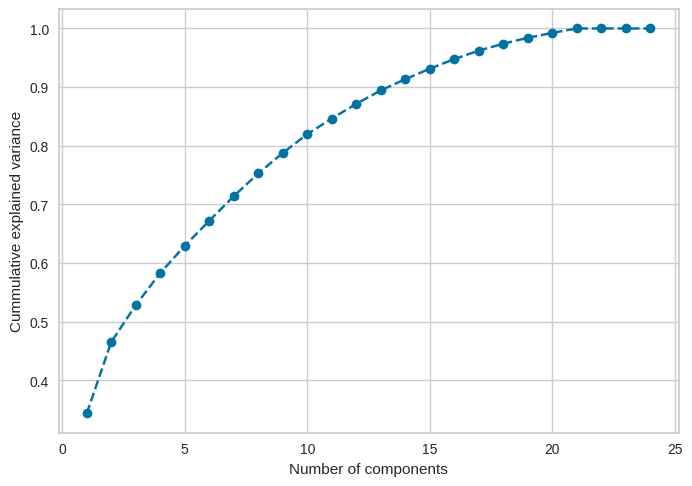

In [31]:
#Plot variance ratio of PCs
plt.bar(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Variance Ratio')
plt.show()

print('Percentage of cumulative variance of PCs: ', pca.explained_variance_ratio_.cumsum() * 100)

#Plot cummulative explained variance
plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.xlabel('Number of components')
plt.ylabel('Cummulative explained variance')
plt.show()

The number of components we choose ultimately depends on our preference. Typically, it is recommended that the total variance explained by all components should be between 70% to 80%, which would equate to roughly 6 components in this case. Despite this, for the present example, only 2 components will be selected, which should preserve a little over 50% of the variance. While this may not be ideal in social sciences, it is still a reasonable level of variance retention. PC1 is responsible for around 36% of the overall variation in the dataset and has the greatest impact on it.

#### 5.3 Perform pca with chosen number of components


In [32]:
# We choose 3 components
pca = PCA(n_components = 3)

# Fit the model with our data with the 3 selected components
pca.fit(df_scaled)

# The calculated resulting components scores for the elements in our data set:
df_pca = pca.transform(df_scaled)
df_pca = pd.DataFrame(df_pca, columns=['D1', 'D2','D3'])
df_pca

D1        D2        D3
0     4.989826 -0.141932  2.469152
1    -2.858508  0.027590 -1.527683
2     2.619159 -0.737147 -0.282148
3    -2.638534 -1.454074 -0.326130
4    -0.647876  0.173666 -0.122192
...        ...       ...       ...
2231  2.313396  2.434429  0.555446
2232 -3.095275  3.999464 -1.390767
2233  2.676408 -1.886638  0.459637
2234  1.485184  1.642469 -1.788981
2235 -2.726032  1.679111 -0.202304

[2236 rows x 3 columns]

#### 5.4 Get PC scores to find contributions of variables in each PC (optional)

In [33]:
#get PC loadings
loadings = pca.components_

#create a dataframe of PC loadings/scores
df_loadings = pd.DataFrame(loadings.T)

# 16 PCs scores with 23 col names
df_loadings.insert(0, 'col_name', df_before_scale.columns)
df_loadings

col_name         0         1         2
0              Education -0.026657 -0.055737  0.023154
1         Marital_Status -0.027268  0.122856 -0.263735
2                 Income  0.278028  0.162746 -0.213979
3                Kidhome -0.245927  0.015566  0.055911
4               Teenhome -0.099333  0.453049 -0.197766
5            Dt_Customer -0.004896 -0.003421 -0.032895
6                Recency  0.004075  0.018393 -0.019372
7                  Wines  0.255759  0.203438  0.071676
8                 Fruits  0.239210  0.022361  0.000165
9                   Meat  0.283995  0.007523 -0.030275
10                  Fish  0.249334  0.013585 -0.001491
11                Sweets  0.236886  0.036494  0.003129
12                  Gold  0.188833  0.141686  0.180072
13     NumDealsPurchases -0.077679  0.366254  0.291516
14       NumWebPurchases  0.166545  0.300293  0.236072
15   NumCatalogPurchases  0.277040  0.105612 -0.031575
16     NumStorePurchases  0.241354  0.204219  0.001181
17     NumWebVisitsMonth -0.225421  0.072841  0.451394
18  Days_since_enrolment  0.031494  0.133304  0.564099
19                   Age  0.037174  0.214880 -0.274203
20              Children -0.247964  0.339158 -0.103163
21           Family_Size -0.219921  0.345931 -0.224621
22             Is_Parent -0.243043  0.294682  0.001831
23                 Spent  0.320542  0.134063  0.044399

The variables Income and Spent make the most significant contribution to PC1. The variables Teenhome, Children, Family_Size, and Is_Parent are the primary contributors to PC2.

#### 5.5 Plot PCA with 3 components

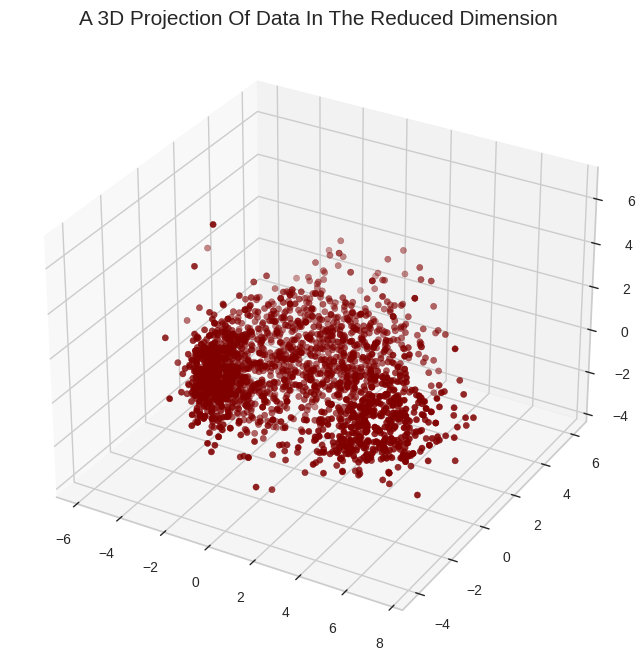

In [34]:
x =df_pca["D1"]
y =df_pca["D2"]
z =df_pca["D3"]
#To plot
fig = plt.figure(figsize=(10,8))
a = fig.add_subplot(111, projection="3d")
a.scatter(x,y,z, c="maroon", marker="o" )
a.set_title("A 3D Projection Of Data In The Reduced Dimension", size=15)
plt.show()

#### 5.6 Dimensionality Reduction using T-SNE

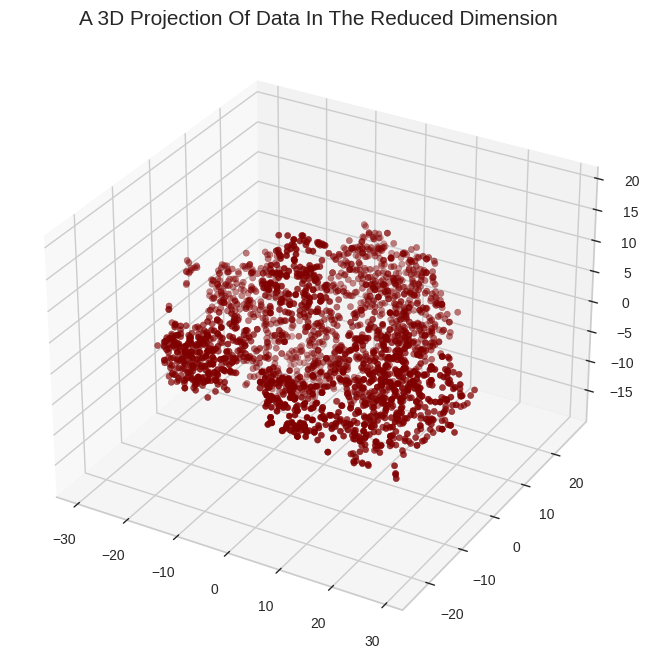

In [35]:
from sklearn.manifold import TSNE

# Apply t-SNE on the df_scaled data
tsne = TSNE(n_components=3, random_state=42)
df_tsne = tsne.fit_transform(df_scaled)
df_tsne = pd.DataFrame(df_tsne, columns=['D1', 'D2', 'D3'])

x =df_tsne["D1"]
y =df_tsne["D2"]
z =df_tsne["D3"]

# Plot t-SNE
fig = plt.figure(figsize=(10,8))
a = fig.add_subplot(111, projection="3d")
a.scatter(x,y,z, c="maroon", marker="o" )
a.set_title("A 3D Projection Of Data In The Reduced Dimension", size=15)
plt.show()

# 6. Clustering
We have completed dimensionality reduction (but the explained variance was not very good). As a result, we can move on to clustering. To determine the best number of clusters to create, we will utilize the elbow method.

#### 6.1 Finding number of clusters using elbow method

Elbow Method to determine the number of clusters to be formed:


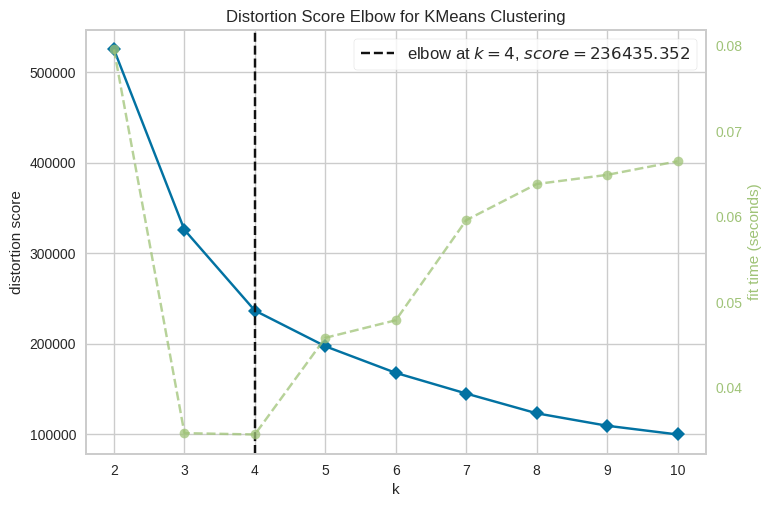

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [36]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(df_tsne)
Elbow_M.show()

#### 6.2 Find the best clustering method

In [37]:
# Define clustering methods
clustering_methods = [cluster.KMeans,
                      cluster.AgglomerativeClustering,
                      cluster.MeanShift,
                      cluster.AffinityPropagation,
                      cluster.SpectralClustering,
                      cluster.Birch
                     ]

data_arg = [(),(),(),(),(),(),()]


# Define parameters for each clustering method
clustering_para = [{'n_clusters':4},
                   {'n_clusters':4, 'linkage':'ward'},
                   {'cluster_all':False},
                   {'damping' : 0.9},
                   {'n_clusters':4},
                   {'threshold' : 0.01, 'n_clusters':4}
                  ]


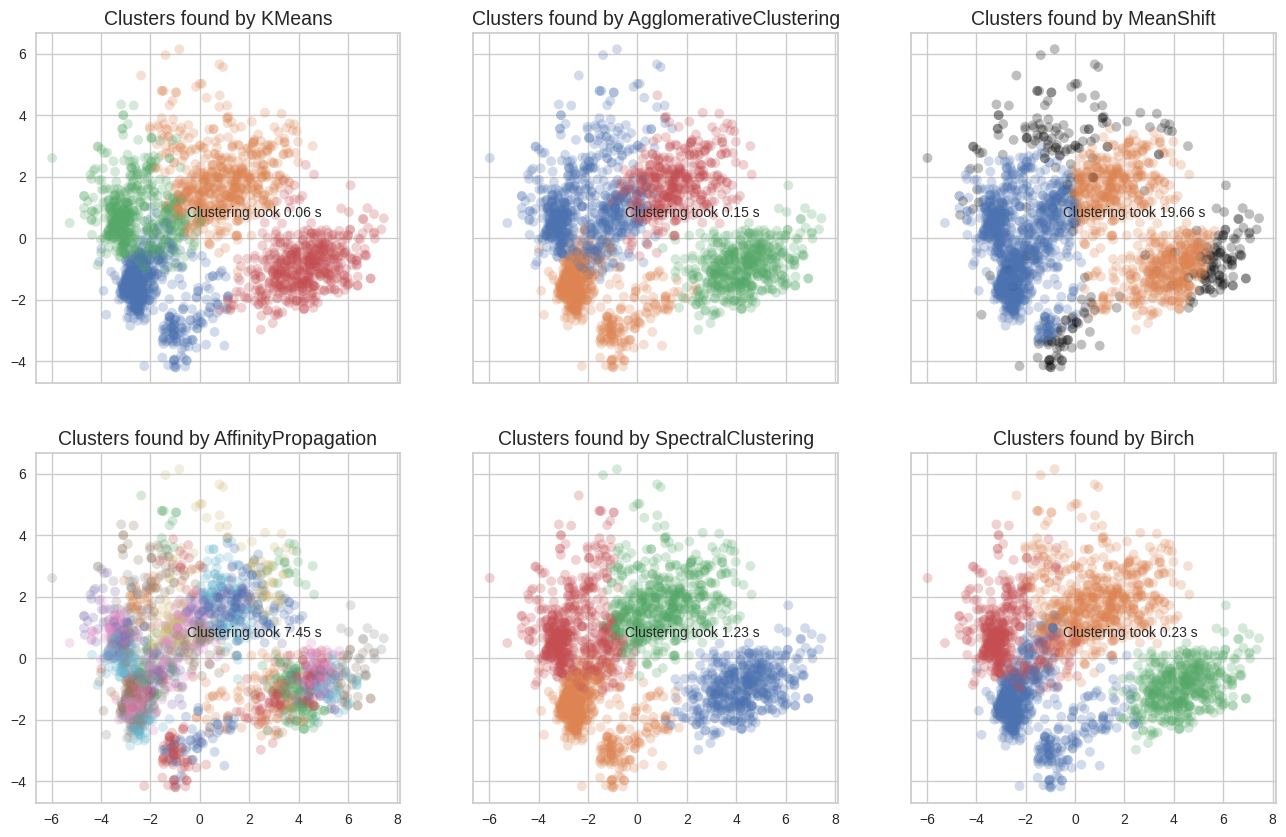

In [38]:
plot_kwds = {'alpha' : 0.25, 's' : 50, 'linewidths':0}
clusters_series = []

def plot_clusters(data, algorithms, args, kwds, axs):
    for j, i in enumerate(axs):
        algorithm = algorithms[j]
        start_time = time.time()
        labels = algorithm(*args[j], **kwds[j]).fit_predict(data)
        end_time = time.time()
        clusters_series.append(labels)
        
        #plotting
        palette = sns.color_palette('deep', np.unique(labels).max() + 1)
        colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]        
        i.scatter(data.iloc[:,0], data.iloc[:,1],c=colors,  **plot_kwds)
        i.set_title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=14)
        i.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=10)
    
    
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16, 10), sharex=True, sharey=True)
axs = axs.flatten()


plot_clusters(data=df_pca, 
              algorithms=clustering_methods, 
              args=data_arg, 
              kwds=clustering_para, 
              axs=axs)

In [39]:
X = df_pca
# Compute the silhouette score for each method
for method, params in zip(clustering_methods, clustering_para):
    model = method(**params)
    y_pred = model.fit_predict(X)
    score = silhouette_score(X, y_pred)
    print(f"Silhouette score for {type(model).__name__}: {score:.3f}")

Silhouette score for KMeans: 0.374
Silhouette score for AgglomerativeClustering: 0.333
Silhouette score for MeanShift: 0.343
Silhouette score for AffinityPropagation: 0.271
Silhouette score for SpectralClustering: 0.367
Silhouette score for Birch: 0.352


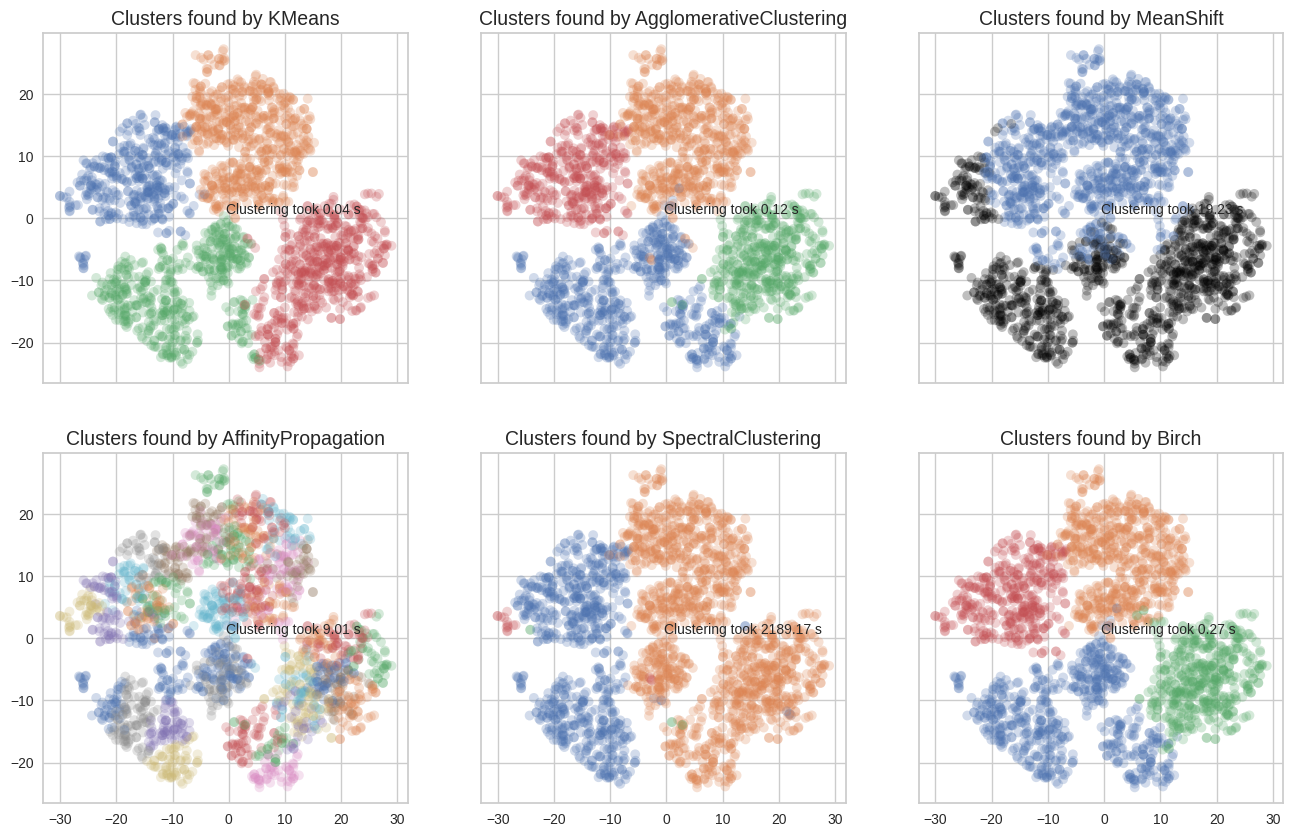

In [40]:
plot_kwds = {'alpha' : 0.25, 's' : 50, 'linewidths':0}
clusters_series = []

def plot_clusters(data, algorithms, args, kwds, axs):
    for j, i in enumerate(axs):
        algorithm = algorithms[j]
        start_time = time.time()
        labels = algorithm(*args[j], **kwds[j]).fit_predict(data)
        end_time = time.time()
        clusters_series.append(labels)
        
        #plotting
        palette = sns.color_palette('deep', np.unique(labels).max() + 1)
        colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]        
        i.scatter(data.iloc[:,0], data.iloc[:,1],c=colors,  **plot_kwds)
        i.set_title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=14)
        i.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=10)
    
    
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16, 10), sharex=True, sharey=True)
axs = axs.flatten()


plot_clusters(data=df_tsne, 
              algorithms=clustering_methods, 
              args=data_arg, 
              kwds=clustering_para, 
              axs=axs)

In [41]:
X = df_tsne
# Compute the silhouette score for each method
for method, params in zip(clustering_methods, clustering_para):
    model = method(**params)
    y_pred = model.fit_predict(X)
    score = silhouette_score(X, y_pred)
    print(f"Silhouette score for {type(model).__name__}: {score:.3f}")

Silhouette score for KMeans: 0.408
Silhouette score for AgglomerativeClustering: 0.385
Silhouette score for MeanShift: 0.279
Silhouette score for AffinityPropagation: 0.289
Silhouette score for SpectralClustering: -0.140
Silhouette score for Birch: 0.386


The clustering methods show minimal variation and are relatively similar to each other, except for Spectral Clustering. Since KMeans has the highest Silhouette score of 0.408, we will use this method for clustering.

#### 6.3 Plot clusters of Kmeans clustering

In [42]:
#Choose KMeans method from clusters series above
df['Clusters'] = clusters_series[0]

In [43]:
fig = go.Figure(data=[go.Scatter3d(
    x=x,y=y,z=z,mode='markers',
    marker=dict(size=6,color=df['Clusters'],colorscale='Viridis',opacity=0.8))])

# tight layout
fig.update_layout( title={'text': "3D scatterplot of kmeans model clusters",'y':0.9,
        'x':0.5,'xanchor': 'center','yanchor': 'top'},
                  margin=dict(l=200, r=220, b=0, t=0))
fig.show()

# 7.Evaluation Matrix
As this is an unsupervised clustering process, there is no labeled feature to use for evaluating or scoring our model. Instead, the goal of this section is to examine the patterns within the formed clusters and understand their nature. To achieve this, we will conduct exploratory data analysis to examine the data in relation to the clusters and draw conclusions from our observations. To begin, we will examine the distribution of groups within the clusters.

#### 7.1 Distribution of clusters


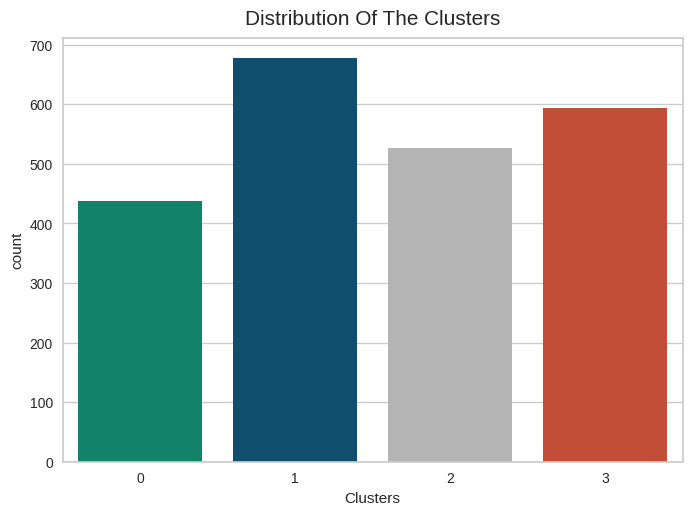

In [44]:
#Plotting countplot of clusters
pl = sns.countplot(x=df["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters", pad=10, size = 15)
plt.show()

These clusters show a relatively even distribution across the dataset. Since we identified that Income and Spent have significant contributions to the distribution, we will create a plot of the clusters based on these two variables.

#### 7.2 Clusters based on income and time spent

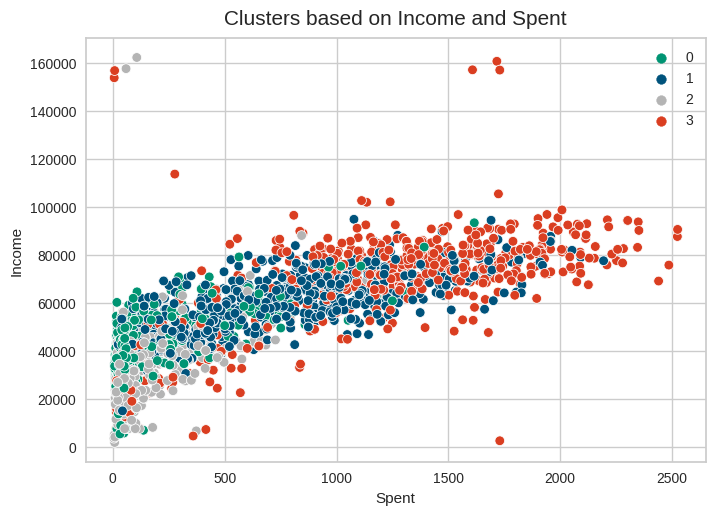

In [45]:
pl = sns.scatterplot(data = df, x = df['Spent'], y = df['Income'], hue = df['Clusters'], palette = pal)
pl.set_title('Clusters based on Income and Spent', pad=10, size=15)
plt.legend()
plt.show()

As shown above, Income and Spent have a strong relationship. Clusters shows a more detail insights into their patterns:

Group 0: high spending and average income

Group 3: high spending and high income

Group 2: low spending and low income

Group 1: low spending and average income


To make it more comprehensible, we will classify Group 0 as good customers, Group 1 as potential good customers, Group 2 as ordinary customers, and Group 3 as elite customers.

In [46]:
#Define name of customer groups according to clusters
re_clust = {
    0: 'Good Customer',
    1: 'Potential Good Customer',
    2: 'Ordinary Customer',
    3: 'Elite Customer'}
df['Clusters_Customers'] = df['Clusters'].map(re_clust)

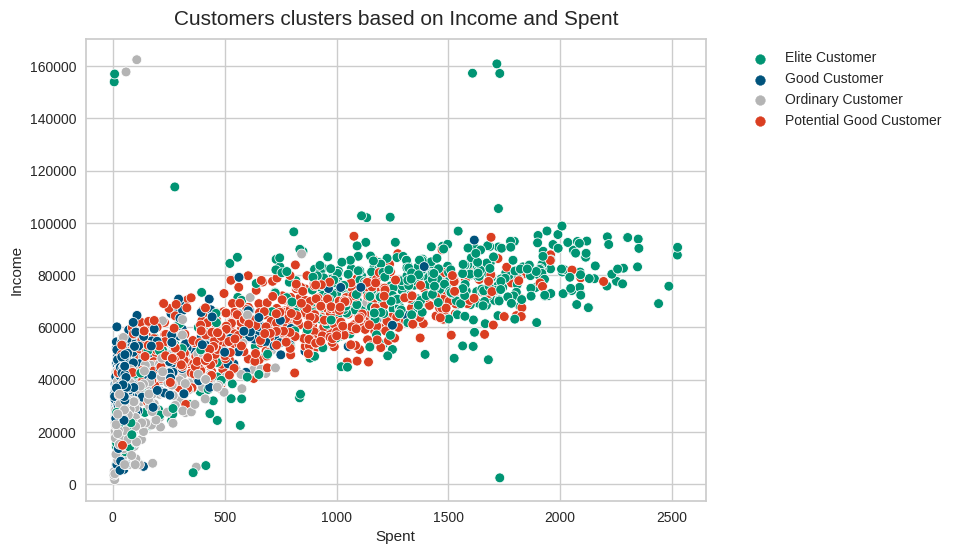

In [47]:
#Plot clusters of customers based on Income and Spent
plt.figure(figsize=(8, 6))
pl = sns.scatterplot(data = df, x = df['Spent'], y = df['Income'], hue = df['Clusters_Customers'], palette = pal, s=50)
pl.set_title('Customers clusters based on Income and Spent', pad=10, size=15)
plt.legend(loc = 'upper right', bbox_to_anchor=(1.4, 1))
plt.show()
plt.show()

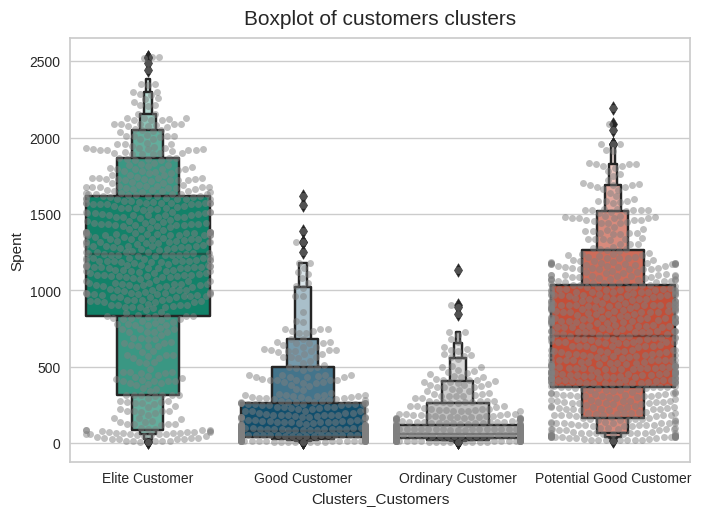

In [48]:
#Plot detailed distribution of cluster through boxplot
plt.figure()
pl=sns.swarmplot(x=df["Clusters_Customers"], y=df["Spent"], color= "gray", alpha=0.5 )
pl=sns.boxenplot(x=df["Clusters_Customers"], y=df["Spent"], palette=pal)
pl.set_title("Boxplot of customers clusters", pad=10, size=15)
plt.show()

The box plot indicates that Elite and Good customers spend significantly more per customer, averaging at £1400 and £800 respectively, compared to Ordinary and Potentially good customers whose spending range is around £500 only. As a result, different marketing campaigns will be developed for each group. To begin this process, we will examine the past marketing campaigns to see how much each group spent on the targeted marketing strategies.

#### 7.3 Clusters based on products spending

In [49]:
#Calculate spending of different products of each customer group

#Group by clusters_customers and calculate total amount of spending by each product
spending_by_product = df.groupby('Clusters_Customers')[['Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold']].sum()

#Transpose the result
spending_by_product = spending_by_product.transpose()

#Reset the index 
spending_by_product = spending_by_product.reset_index()

#Rename column
spending_by_product = spending_by_product.rename(columns = {'index': 'Category'})

spending_by_product

Clusters_Customers Category  Elite Customer  Good Customer  Ordinary Customer  \
0                     Wines          310604          52700              23491   
1                    Fruits           33123           2628               3691   
2                      Meat          240238          19280              16619   
3                      Fish           48628           3740               4908   
4                    Sweets           33826           2987               3760   
5                      Gold           40767           9518               9881   

Clusters_Customers  Potential Good Customer  
0                                    293234  
1                                     19311  
2                                     97238  
3                                     26655  
4                                     19979  
5                                     38180

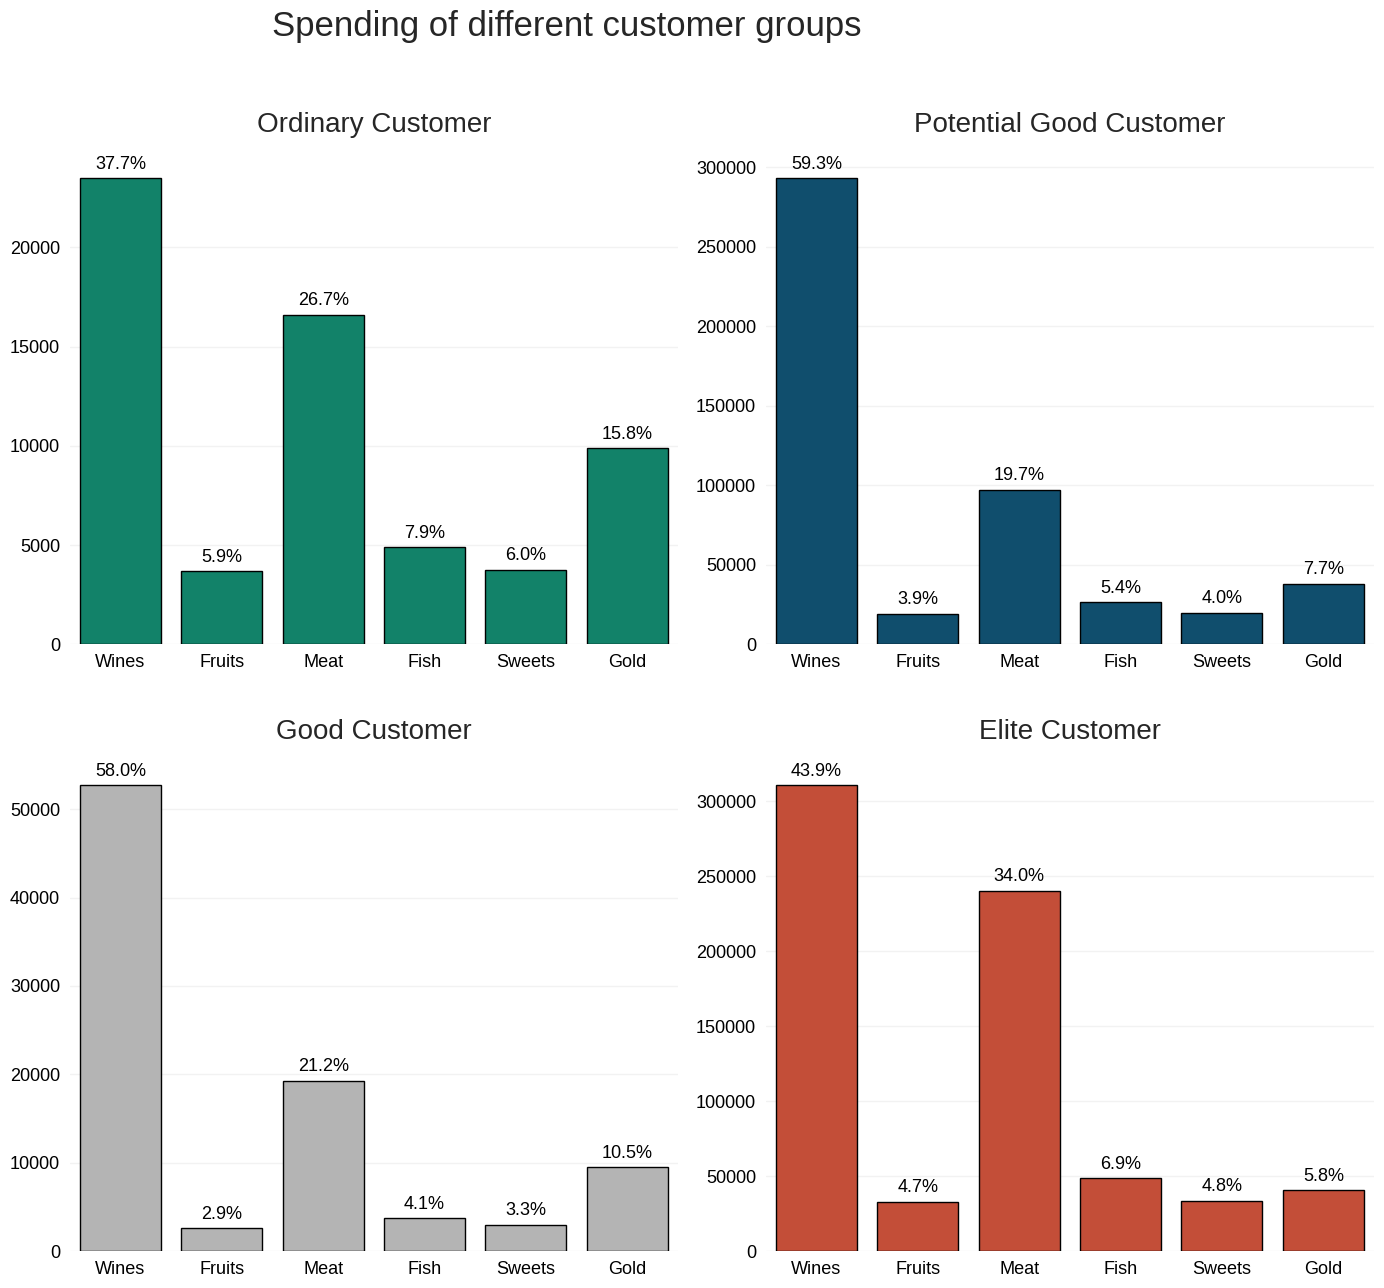

In [50]:
# Plot bar charts
#Creates a figure with 4 subplots using the subplots() function from matplotlib
fig = plt.figure(figsize=(14, 12)) 

#Initializes k=1 and creates a list cl of strings representing the names of each customer cluster
k = 1
cl = ['Ordinary Customer', 'Potential Good Customer', 'Good Customer', 'Elite Customer']

#
for i in cl:
    #only the columns Category and i are selected, where i is the current iteration of the cl list 
    ass = spending_by_product[['Category', i]]
    
    #create a subplot in a grid with 2 rows and 2 columns, and it sets the current subplot to the k position
    plt.subplot(2, 2, k)
    plt.title(i, size = 20, x = 0.5, y = 1.03)
    plt.grid(color = 'gray', linestyle = '-', axis = 'y', alpha = 0.1)
    cluster_color = pal[k-1]
    
    #create barplot using seaborn where x is products in the category, y is the current iteration of the cl list
    a = sns.barplot(data = ass, x = 'Category', y = i, color = cluster_color, linestyle = "-", linewidth = 1, edgecolor = "black")
    plt.xticks(size = 13, color = 'black')
    plt.yticks(size = 13, color = 'black')
    plt.xlabel('')
    plt.ylabel('')
    
    #add annotations to the barplot by percentage of spending amount
    for p in a.patches:
        #set the x-coordinate to the center of the current bar patch
        x_pos = p.get_x() + p.get_width() / 2
        
        #get the height of the current patch
        y_pos = p.get_height()
        
        #calculate percentage of spending amount (current patch) and the total spending of the group
        percentage = round((y_pos / sum(ass[i])) * 100, 1)
        a.annotate(
            f'{percentage}%', #text to be displayed
            xy=(x_pos, y_pos), #position to be placed
            ha='center', va='center', #alignment of the text
            size=13, 
            color='black',
            xytext = (0, 10), 
            textcoords = 'offset points')
    
    #hide spines of the barplot (the right, top, left and bottom borders)
    for spine in ['right', 'top', 'left', 'bottom']:
        a.spines[spine].set_visible(False)
        
    #increment k after iteration of the loop
    k += 1

plt.figtext(0.2, 1.05, 'Spending of different customer groups', size = 25)
fig.tight_layout(h_pad = 3)
plt.show()

All four groups spent the highest amount on Wines, followed by Meat, out of six different products.

In terms of purchasing Gold, Ordinary and Potentially good customers are more inclined to do so, with percentages of 17.7% and 10.5% respectively, while the other two groups only have percentages of 8% and 5.4%.

Elite customers, on the other hand, have a greater tendency to buy Meat, accounting for around £240,000 or 33.9% of their total spending, which is higher than the other groups' spending of less than 26%.


#### 7.4 Clusters based on Promotions

In [51]:
#Creating a feature to get a sum of accepted promotions 
df["Total_Promos"] = df["AcceptedCmp1"]+ df["AcceptedCmp2"]+ df["AcceptedCmp3"]+ df["AcceptedCmp4"]+ df["AcceptedCmp5"]

# Group the data by cluster and sum the total number of promotions accepted
cluster_promos = df.groupby('Clusters_Customers')[['Total_Promos']].sum().reset_index()

# Calculate the percentage of promotions accepted for each cluster
cluster_promos['Percentage_Promos'] = round(cluster_promos['Total_Promos']*100/ cluster_promos['Total_Promos'].sum(), 2)

cluster_promos

Clusters_Customers  Total_Promos  Percentage_Promos
0           Elite Customer           375              56.31
1            Good Customer            50               7.51
2        Ordinary Customer            58               8.71
3  Potential Good Customer           183              27.48

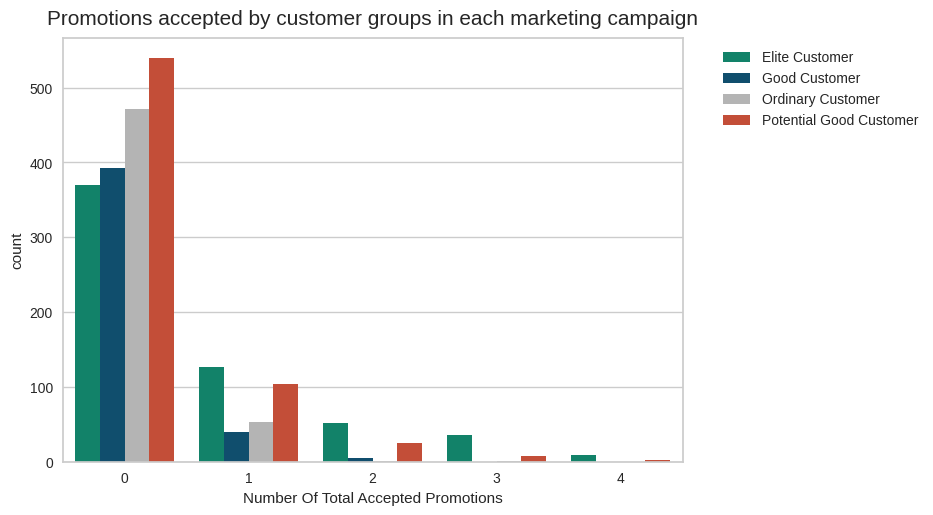

In [52]:
plt.figure()
pl = sns.countplot(x=df["Total_Promos"],hue=df["Clusters_Customers"], palette= pal)
pl.set_title("Promotions accepted by customer groups in each marketing campaign", pad=10, size=15)
pl.set_xlabel("Number Of Total Accepted Promotions")
plt.legend(loc = 'upper right', bbox_to_anchor=(1.4, 1))
plt.show()

For the initial marketing campaign, the Ordinary and Potentially good customer groups had around 500 acceptances each, while the Good and Elite customer groups had 400 and 300 acceptances respectively.

In subsequent campaigns, the number of accepted promotions declined significantly. The Ordinary and Potentially good customers tent to not accept the offer, while only a small portion of the Good and Elite customers accepted it.

#### 7.5 Clusters based on Number of Deals Purchased

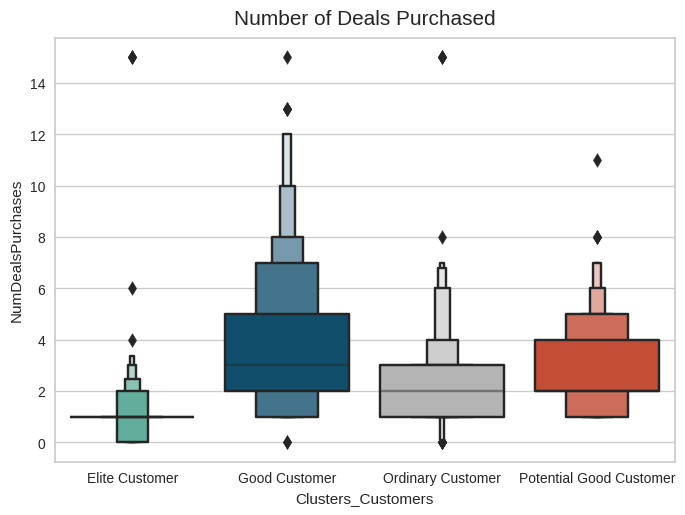

In [53]:
plt.figure()
pl=sns.boxenplot(x=df["Clusters_Customers"], y=df["NumDealsPurchases"], palette= pal)
pl.set_title("Number of Deals Purchased", pad=10, size=15)
plt.show()

The deals seem to be successful in the groups of good customers and potential good customers. However, the group of elite customers did not show the interest in the deals offered.

# 8. PROFILING
Now we have formed the clusters and looked at their purchasing habits. Let us see who all are there in these clusters. For that, we will be profiling the clusters formed and come to a conclusion about who is our star customer and who needs more attention from the retail store's marketing team.

To decide that I will be plotting some of the features that are indicative of the customer's personal traits in light of the cluster they are in. On the basis of the outcomes, I will be arriving at the conclusions.

<Figure size 800x550 with 0 Axes>

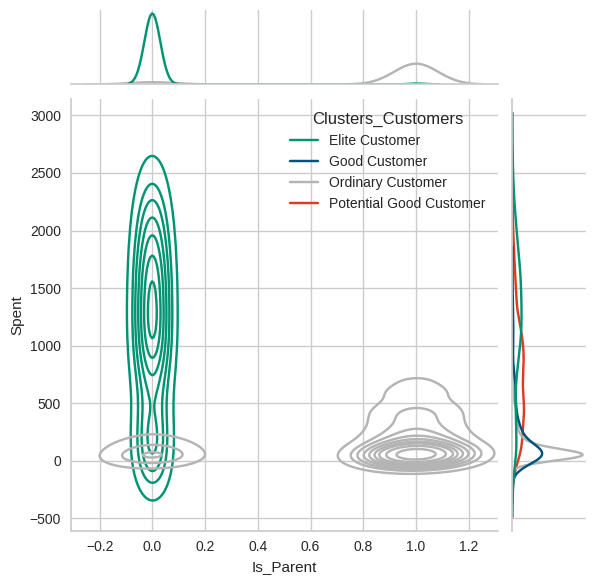

<Figure size 800x550 with 0 Axes>

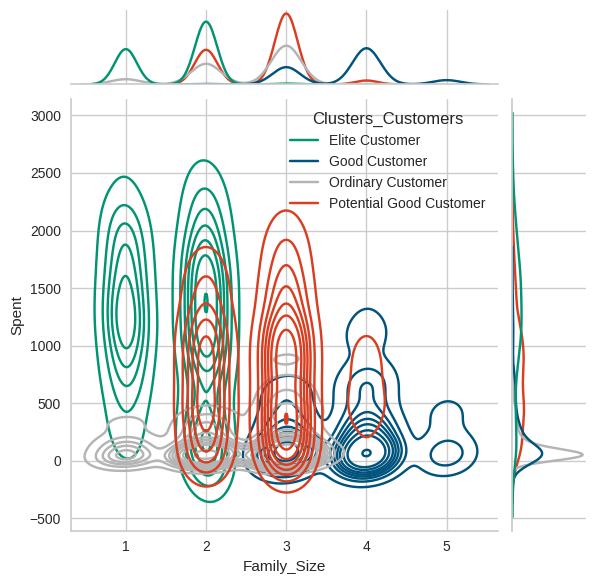

<Figure size 800x550 with 0 Axes>

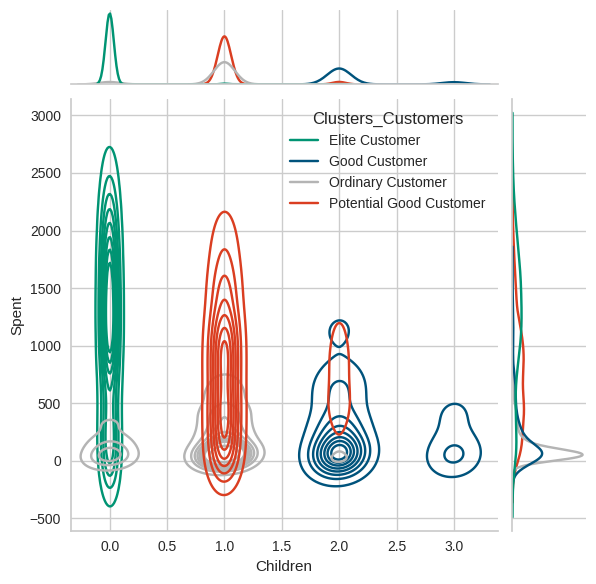

<Figure size 800x550 with 0 Axes>

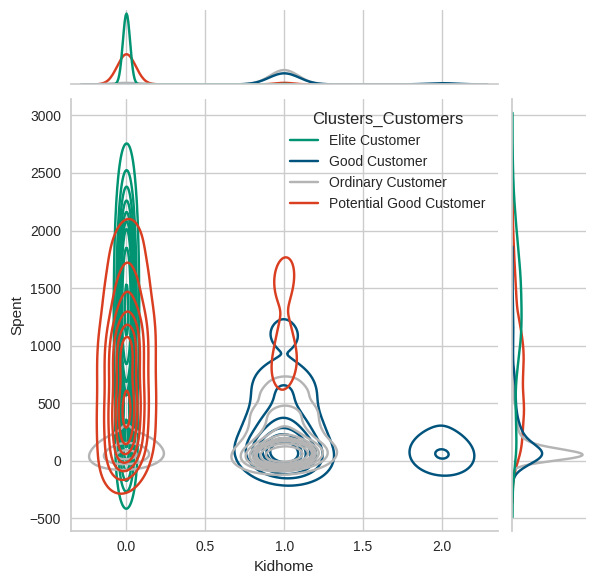

<Figure size 800x550 with 0 Axes>

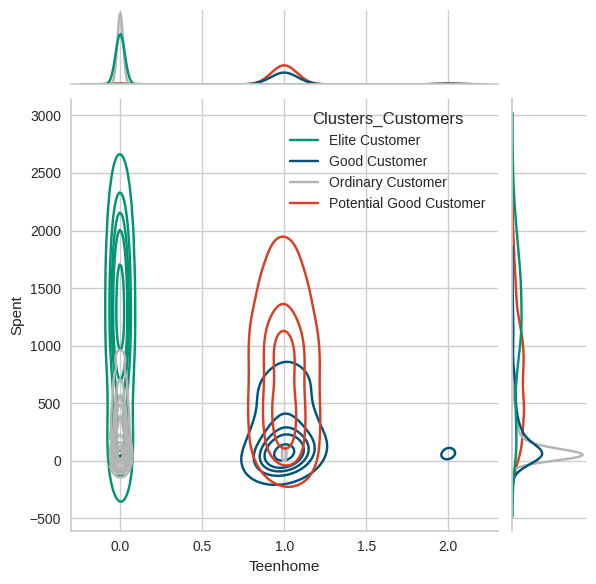

<Figure size 800x550 with 0 Axes>

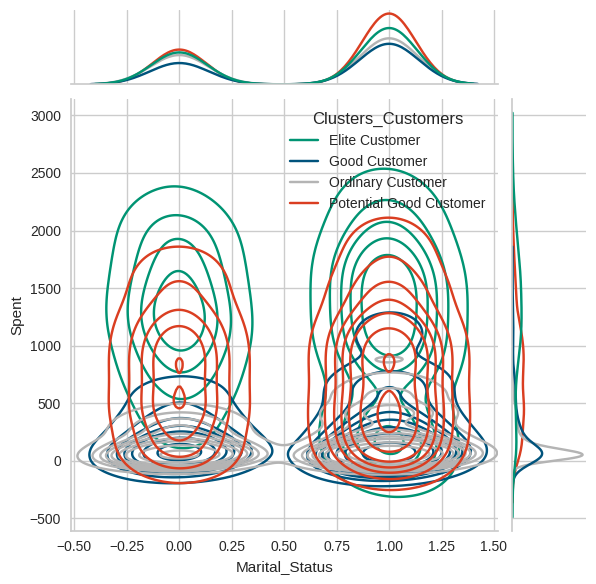

<Figure size 800x550 with 0 Axes>

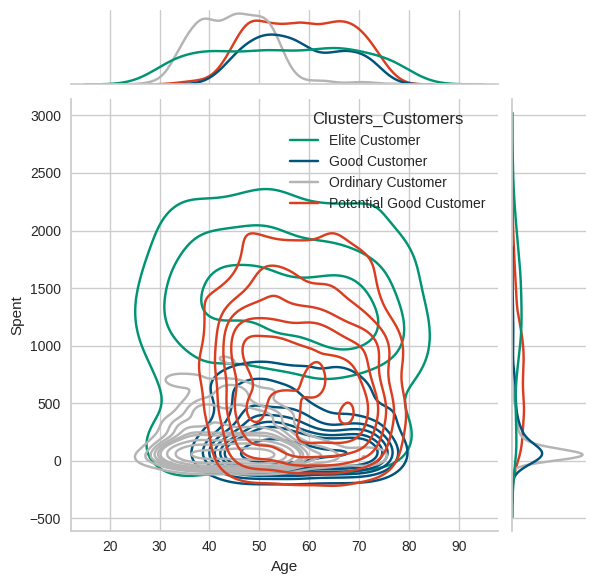

<Figure size 800x550 with 0 Axes>

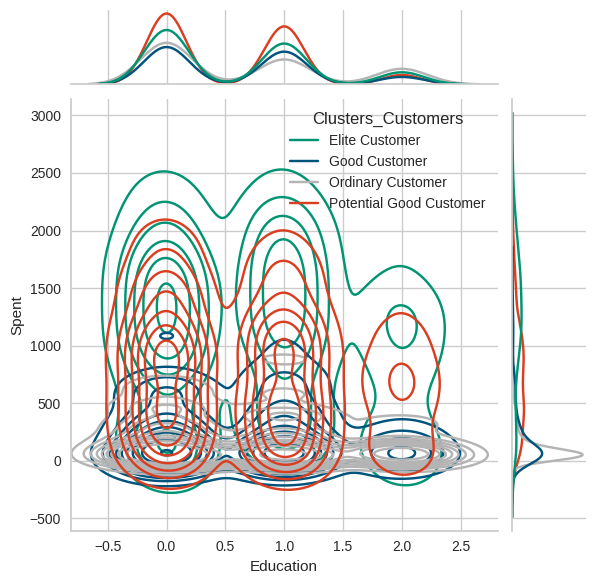

In [54]:
Personal = ["Is_Parent", "Family_Size", "Children", "Kidhome","Teenhome",
            "Marital_Status", "Age", "Education"]

for i in Personal:
    plt.figure()
    sns.jointplot(x=ds[i], y=df["Spent"], hue =df["Clusters_Customers"], kind="kde", palette=pal)
    plt.show()

**After analysing these barplots, we can easily characterise the four customers:**
1. Elite Customer
* High spending and high income
* Not parents
* Maximum family size of 2, no children
* There are greater number of couples than single ones.

2. Good Customer
* High spending and average income
* Have children.
* Most of them have teenagers.
* Family size ranges from 2-4
* Middle aged

3. Potentially good customer
* Low spending and average income
* Family size varies from 3-6
* Have more than 2 children
* Have both teens and kids.

4. Ordinary Customer
* Low spending and low income
* Most of them are parents.
* Maximum family size is 4.
* Typically have 1 child (usually a kid)



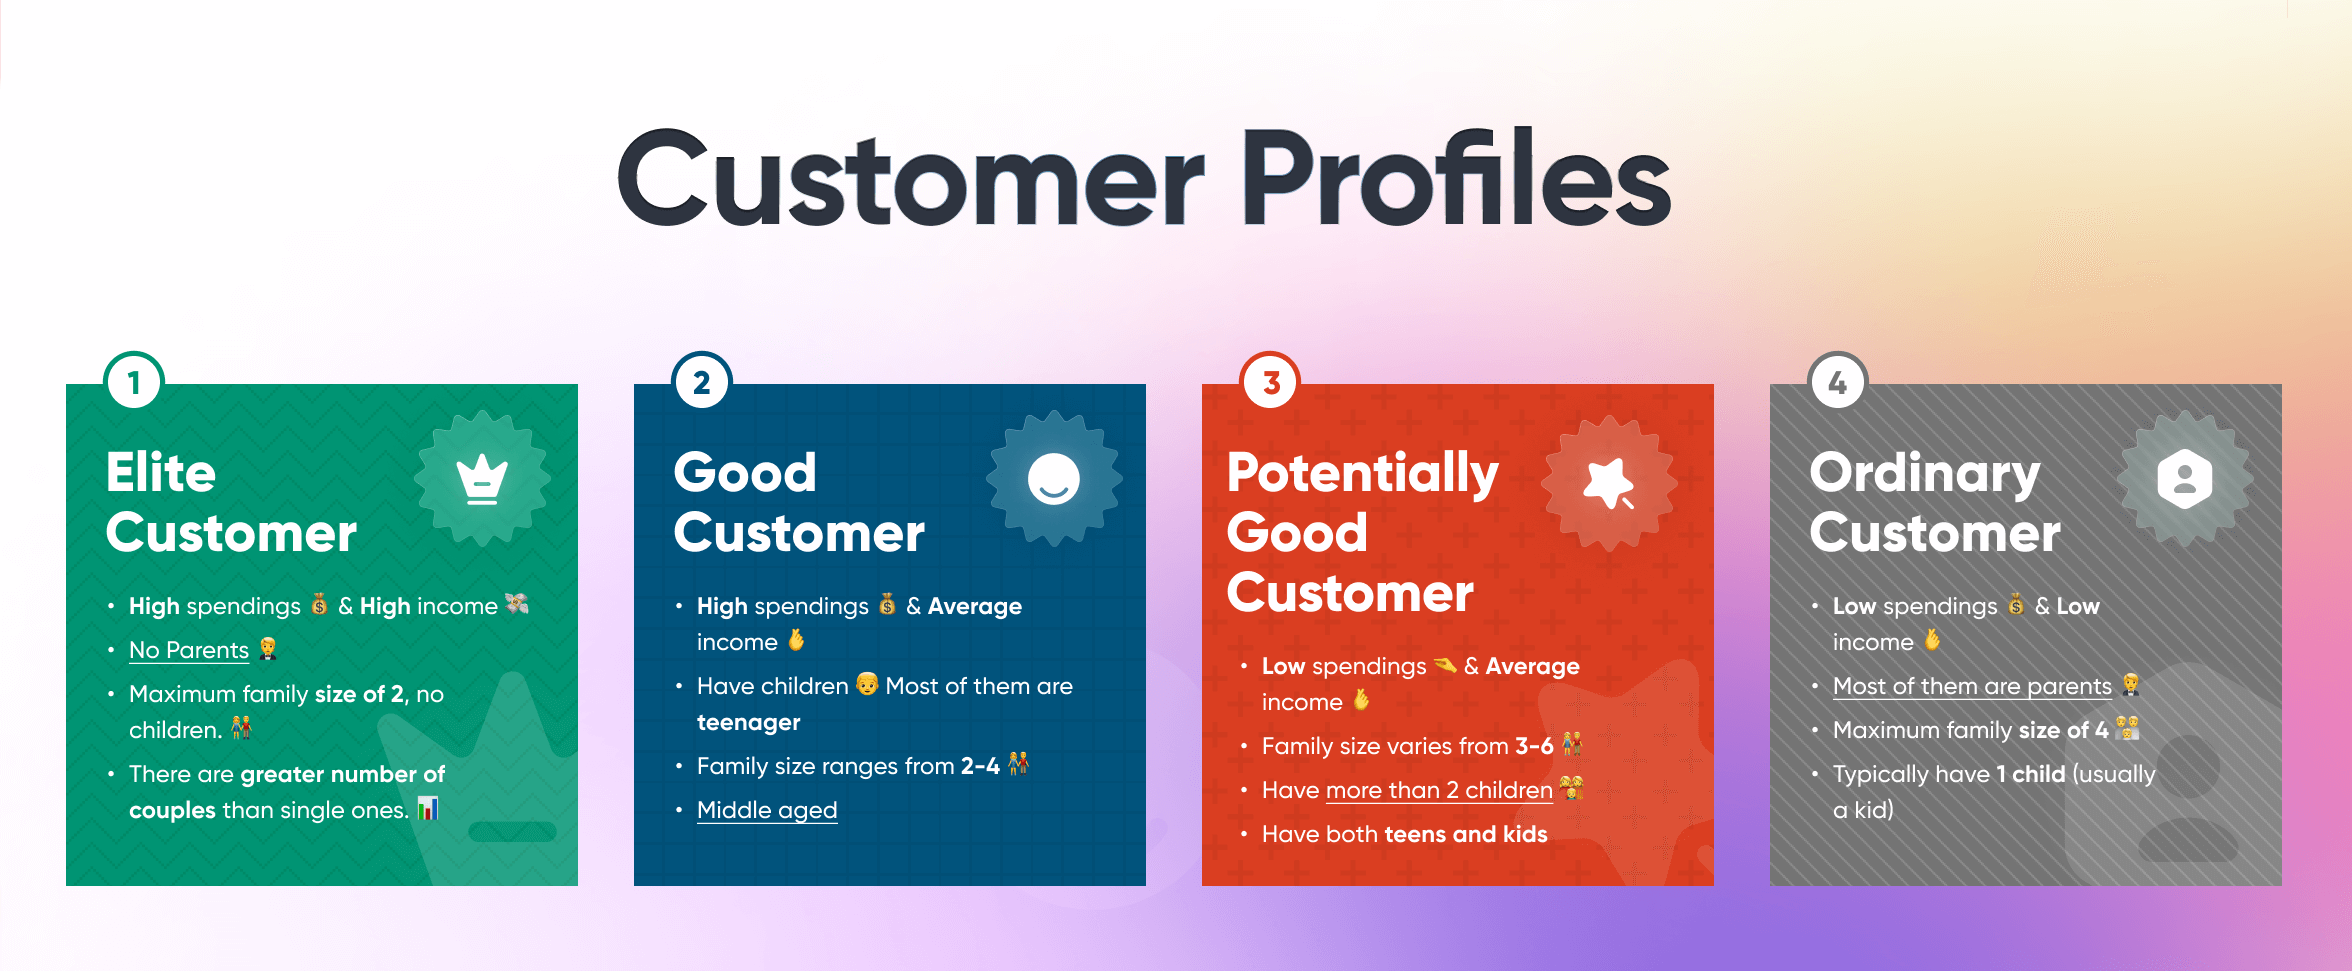

# 9. Conclusion

After creating these distinct customer profiles, it is crucial to leverage this valuable information to drive marketing success. Refine targeted marketing campaigns by tailoring messaging, offers, and creative content to align with each customer segment's preferences. Implement personalization strategies that resonate with the intended audience and convey a sense of individualized experience. By leveraging customer profiles effectively, we can create meaningful connections with our customers, enhance engagement, and increase the likelihood of conversion and long-term loyalty.